In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [59]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

In [60]:
df_fake['Label'] = 0
df_true['Label'] = 1


In [61]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [62]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1    

In [63]:
j

21247

In [64]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')

In [65]:
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

In [66]:
final_data = pd.concat([df_fake, df_true], axis=0)
final_data

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [67]:
final_data = final_data.sample(frac=1).reset_index(drop=True)

In [68]:
final_data.drop_duplicates(inplace=True)

In [69]:
final_data.duplicated().sum()

0

In [70]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text

In [71]:
final_data['text']=final_data['text'].apply(reuters_removal)

In [72]:
final_data.isnull().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [73]:
final_data=final_data[["text","Label"]]
final_data

,text,Label
0,21st Century Wire says Our weekly documentary ...,0
1,NEW YORK - U.S. presidential hopeful Donald Tr...,1
2,"On Thursday, while Republican leadership was m...",0
3,ISTANBUL - Turkey s Vakifbank said on Friday i...,1
4,"Ahead of tomorrow night s debates, where Hilla...",0
...,...,...
44872,"Father Robert A. Sirico, President and Co-Foun...",0
44873,"WASHINGTON - Kevin Hassett, an economist at th...",1
44874,The winning streak continues for Bernie Sander...,0
44875,"Remember the name Felix Sater, because it s go...",0


In [77]:
port_stemmer= PorterStemmer()

In [78]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Наталья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
def stemmer(content):
    stemmed_content=re.sub('[^a-zA-Z]',' ', content)
    stemmed_content= stemmed_content.lower()
    stemmed_content= stemmed_content.split()
    stemmed_content= [port_stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content= ' '.join(stemmed_content)
    return stemmed_content

In [80]:
final_data['text']= final_data['text'].apply(stemmer)

In [83]:
max_len=100
data_text=final_data["text"]
data_label=final_data["Label"]

In [84]:
! pip install transformers

You should consider upgrading via the 'C:\Users\Наталья\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [85]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [86]:
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

In [87]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [88]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [89]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [91]:
def tokenize(X):
    
    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [92]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [93]:
maxlen=100

In [94]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model
    
    

In [95]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [96]:
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [97]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [98]:
history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=10, validation_split = 0.2, batch_size = 30, callbacks=[callback])

Epoch 1/10
953/953 [==============================] - 19434s 20s/step - loss: 0.1436 - accuracy: 0.9435 - val_loss: 0.0706 - val_accuracy: 0.9750
Epoch 2/10
953/953 [==============================] - 20889s 22s/step - loss: 0.0666 - accuracy: 0.9782 - val_loss: 0.0565 - val_accuracy: 0.9806
Epoch 3/10
953/953 [==============================] - 15374s 16s/step - loss: 0.0564 - accuracy: 0.9817 - val_loss: 0.0550 - val_accuracy: 0.9815
Epoch 4/10
953/953 [==============================] - 15030s 16s/step - loss: 0.0497 - accuracy: 0.9836 - val_loss: 0.0503 - val_accuracy: 0.9829
Epoch 5/10
953/953 [==============================] - 15704s 16s/step - loss: 0.0472 - accuracy: 0.9849 - val_loss: 0.0564 - val_accuracy: 0.9810
Epoch 6/10
953/953 [==============================] - 14522s 15s/step - loss: 0.0424 - accuracy: 0.9866 - val_loss: 0.0550 - val_accuracy: 0.9813
Epoch 7/10
953/953 [==============================] - 14535s 15s/step - loss: 0.0414 - accuracy: 0.9872 - val_loss: 0.0569 -

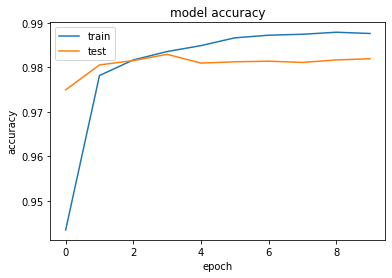

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


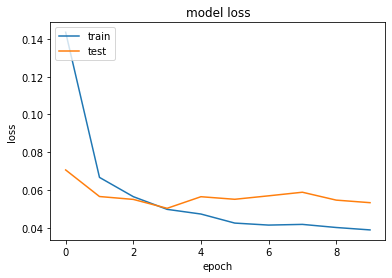

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

280/280 [==============================] - 2209s 8s/step


In [103]:
!pip install mlxtend

You should consider upgrading via the 'C:\Users\Наталья\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.



     ---------------------------------------- 1.4/1.4 MB 7.1 MB/s eta 0:00:00


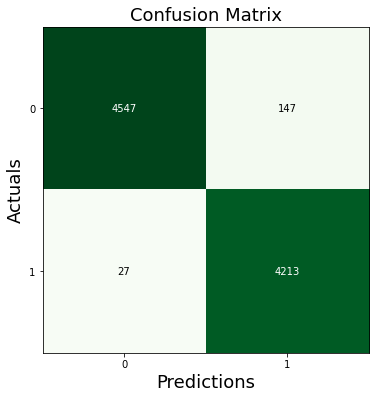

In [104]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [105]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4694
           1       0.97      0.99      0.98      4240

    accuracy                           0.98      8934
   macro avg       0.98      0.98      0.98      8934
weighted avg       0.98      0.98      0.98      8934



In [3]:
results = model.evaluate({'input_1': X_test_token['input_ids'], 'input_2': X_test_token['attention_mask']}, Y_test, verbose=0)

# Extract the accuracy from the results
accuracy = results[1] * 100  # Accuracy is typically the second metric returned by evaluate()

# Print the total accuracy
print(f'Total Accuracy: {accuracy:.2f}%')

NameError: name 'model' is not defined

In [1]:
results = model.evaluate({'input_1': X_test_token['input_ids'], 'input_2': X_test_token['attention_mask']}, Y_test, verbose=0)

# Extract the accuracy from the results
accuracy = results[1] * 100  # Accuracy is typically the second metric returned by evaluate()

# Print the total accuracy
print(f'Total Accuracy: {accuracy:.2f}%')

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Define your model architecture
def create_model():
    input_layer = Input(shape=(input_shape,))
    hidden_layer = Dense(64, activation='relu', kernel_regularizer='l2')(input_layer)
    dropout_layer = Dropout(0.5)(hidden_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and compile the model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])